# Exploration03 - 카메라 스티커앱 만들기 첫걸음

얼굴을 인식하고 스티커를 붙여보자

---

### 루브릭 평가 기준

1. 카메라앱 기능 구현 완수 - 원본 이미지에 스티커 사진이 정상적으로 합성되었나
2. 정확한 위치에 스티커 반영 - 정확한 좌표계산을 통해 위치가 잘 어울리게 출력되었나
3. 다양한 문제점을 체계적으로 분석 - 얼굴 각도, 이미지 밝기, 촬영 거리 등 다양한 변수에 따른 영향도를 체계적으로 분석하였나

---

### 목차

0) 필요 모듈 import


1) 원본 이미지 분석
  - 이미지 로드 및 확인
  - 얼굴 영역 검출
  - landmark 검출
  
    

2) 스티커 이미지 변형
  - 이미지 로드 및 확인
  - 크기 변경 및 회전
  - 위치 선정


3) 결과 확인
    

4) 다양한 이미지 적용
  - 얼굴의 영역이 작은 이미지 & 여러 사람이 있는 이미지
  - 어두운 이미지


5) 회고


6) 참고 자료

## 0. 필요 모듈 import

In [1]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import dlib
import math

## 1. 원본 이미지 분석

원본 이미지를 분석하여 얼굴 영역을 검출한다.

### - 이미지 로드 및 확인

OpenCV를 이용하여 원본 이미지를 로드하고 확인해보자.

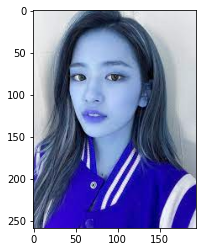

In [2]:
my_image_path = os.getcwd()+'/data/1.jpg'

img_bgr = cv2.imread(my_image_path)
img_show = img_bgr.copy() # 중간 확인용 이미지 복사

plt.imshow(img_bgr)
plt.show()

OpenCV는 다른 이미지 라이브러리와는 달리 이미지 채널을 BGR 순서로 사용하므로 Blue와 Red의 색이 바뀌어 표현된다.  
이를 RGB 순서로 바꾸어 출력해보자.

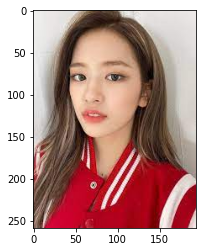

In [3]:
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()

* 인물 이미지는 총 4개가 등장한다.  

  img_bgr(원본 로드) >> img_rgb(결과 이미지)  

  img_show(바운딩 박스) >> img_show_rgb(랜드마크)

### - 얼굴 영역 검출
dlib의 face detector를 이용해 원본 이미지에서 얼굴 영역을 검출해보자.

In [4]:
detector_hog = dlib.get_frontal_face_detector()

dlib_rects = detector_hog(img_rgb, 1)

print(dlib_rects)   

rectangles[[(20, 44) (127, 152)]]


검출한 영역으로 확인용 이미지 복사본 위에 bounding box를 그려보자.

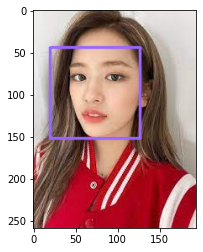

In [5]:
for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(img_show, (l,t), (r,b), (255,102,153), 2, lineType=cv2.LINE_AA)

img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

### - landmark 검출

dlib에서 제공하는 landmark 모델을 이용하여 검출해보자.

In [6]:
model_path = os.getcwd()+'/models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)

In [7]:
list_landmarks = []

for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)

    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

print(len(list_landmarks[0]))

68


68개의 랜드마크는 아래 그림과 같다.

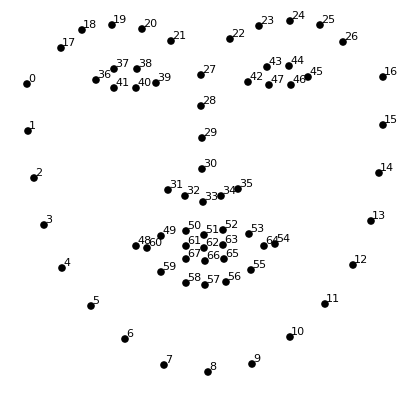

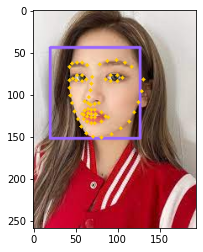

In [8]:
for landmark in list_landmarks:
    for point in landmark:
        cv2.circle(img_show_rgb, point, 2, (255, 204, 0), -1)

plt.imshow(img_show_rgb)
plt.show()

검출된 랜드마크를 통해 기준이 될 좌표와 기울기를 찾는다.

In [9]:
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    x = landmark[33][0] # 코 끝을 기준으로 좌표 추출
    y = landmark[33][1]
    w = h = dlib_rect.width()
    
    # 콧대를 기준으로 기울기 찾기
    tan_theta = (landmark[30][0]-landmark[27][0])/(landmark[30][1]-landmark[27][1]) 
    theta = math.degrees(math.atan(tan_theta))
   
    print ('(x,y) : (%d,%d)'%(x,y))
    print ('(w,h) : (%d,%d)'%(w,h))
    print('rotation degree :', theta)

(x,y) : (68,112)
(w,h) : (108,108)
rotation degree : -9.462322208025617


- 코 끝인 33번의 좌표를 스티커의 위치를 정할 기준으로 삼는다.
- 콧대인 27번과 30번의 좌표를 이용하여 얼굴이 틀어진 각도를 찾는다.
  

## 2. 스티커 이미지 변형

### - 이미지 로드 및 확인

스티커 이미지를 로드하고 직접 확인해보자.

<function matplotlib.pyplot.show(close=None, block=None)>

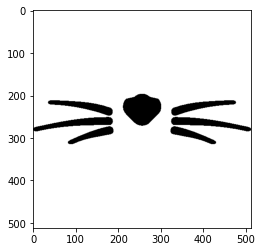

In [10]:
sticker_path = os.getcwd()+'/data/cat.png'
img_sticker = cv2.imread(sticker_path)

plt.imshow(img_sticker)
plt.show

### - 크기 조절 및 회전

검출된 얼굴 영역과 랜드마크에 맞춰 이미지를 변경해보자.

In [11]:
# 스티커 이미지 resize
img_sticker = cv2.resize(img_sticker, (w,h))

In [12]:
#이미지 회전을 위한 함수
def rotate_image(image, angle):
    image_center = (h//2, w//2)
    mat = cv2.getRotationMatrix2D(image_center, angle, 1.0)                 
    dst = cv2.warpAffine(image, mat, (0,0), borderValue=(255,255,255))   # 회전 후 생기는 빈 부분을 흰색으로 채운다
    return dst

1. 스티커 이미지의 중심을 회전 중심으로 한다.
2. 회전 변환 행렬을 정의한다.
3. 어파인 변환을 수행한다.

In [13]:
# 스티커 이미지 회전
img_sticker = rotate_image(img_sticker, theta)

print (img_sticker.shape)

(108, 108, 3)


### - 위치 선정

스티커 이미지의 왼쪽 상단을 기준으로 위치를 정해보자.  
기준점인 코 끝에 스티커의 중심이 위치하도록 좌표를 설정해준다.

In [14]:
refined_x = x - w//2
refined_y = y - h//2
print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

(x,y) : (14,58)


재설정된 좌표가 음수값이 나왔다면 원본 이미지의 영역을 벗어나므로 스티커를 잘라주어야한다.  
이 프로젝트의 경우에는 음수의 좌표값이 나오지는 않지만 다양한 상황에 적용될 것을 고려해 아래의 코드를 추가해준다.

In [15]:
if refined_x < 0: 
    img_sticker = img_sticker[:, -refined_x:]
    refined_x = 0
if refined_y < 0:
    img_sticker = img_sticker[-refined_y:, :]
    refined_y = 0

print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

(x,y) : (14,58)


## 3. 결과 확인

스티커가 제자리에 위치했는지 확인해본다.

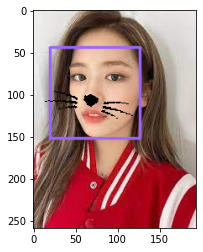

In [16]:
# 스티커 영역 정의
sticker_area = img_show[refined_y:refined_y+h, refined_x:refined_x+w]

# 스티커 영역에서 스티커를 적용할 부분 선택
img_show[refined_y:refined_y+h, refined_x:refined_x+w]= \
    np.where(img_sticker!=0,sticker_area,img_sticker).astype(np.uint8)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

스티커의 위치가 잘 맞는 것을 확인했으니 bounding box와 landmark가 없는 원본 이미지인 img_rgb에 스티커를 올려보자.

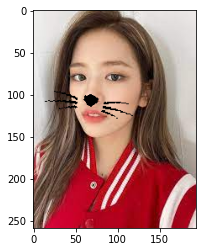

In [17]:
sticker_area = img_rgb[refined_y:refined_y+h, refined_x:refined_x+w]

img_rgb[refined_y:refined_y+h, refined_x:refined_x+w] = \
    np.where(img_sticker!=0,sticker_area,img_sticker).astype(np.uint8)

plt.imshow(img_rgb)
plt.show()

### * 스티커가 정확한 위치에 합성되었으므로 성공!! ♪~ ᕕ( ᐛ )ᕗ

## 4. 다양한 이미지 적용

다양한 상황에서도 적용될 수 있도록 만들어보자.

### - 얼굴의 영역이 작은 이미지 & 여러 사람이 있는 이미지

멀리서 찍어 전체 이미지 중 얼굴의 영역이 작으면서 여러 사람이 있는 이미지에도 스티커를 잘 붙일 수 있을까?

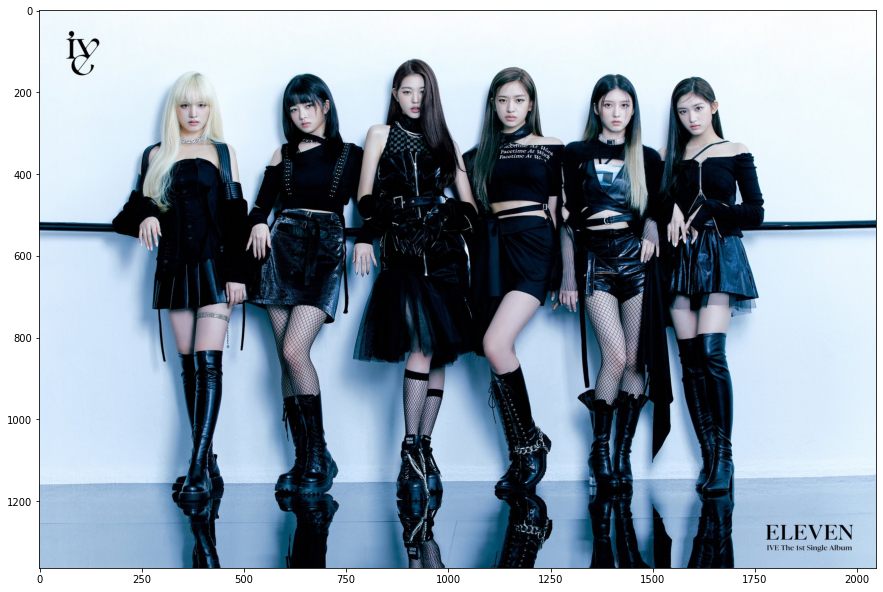

In [18]:
# 원본 이미지 로드
my_image_path = os.getcwd()+'/data/g.jpg'

img_bgr = cv2.imread(my_image_path)
img_show = img_bgr.copy() # 중간 확인용 이미지 복사

img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)  #RGB 순서로 변환

plt.figure(figsize=(15,15))
plt.imshow(img_rgb)
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

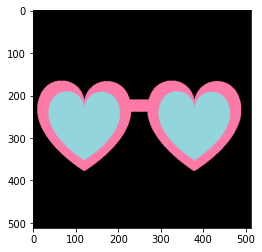

In [19]:
# 스티커 불러오기
sticker_path = os.getcwd()+'/data/sunglasses.png'
img_sticker = cv2.imread(sticker_path)
img_sticker = cv2.cvtColor(img_sticker, cv2.COLOR_BGR2RGB)

plt.imshow(img_sticker)
plt.show

rectangles[[(1111, 196) (1200, 285)], [(1370, 206) (1459, 295)], [(872, 176) (962, 265)], [(335, 206) (424, 295)], [(1559, 216) (1648, 305)], [(610, 221) (685, 296)]]


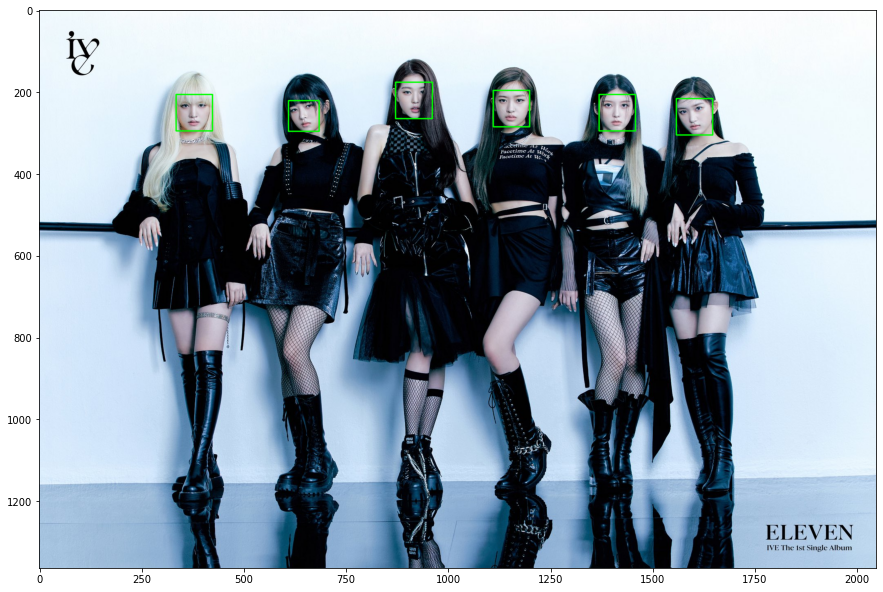

In [20]:
# 얼굴 영역 검출
detector_hog = dlib.get_frontal_face_detector()

dlib_rects = detector_hog(img_rgb, 1)

print(dlib_rects)  

# bounding box 그리기
for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(15,15))
plt.imshow(img_show_rgb)
plt.show()

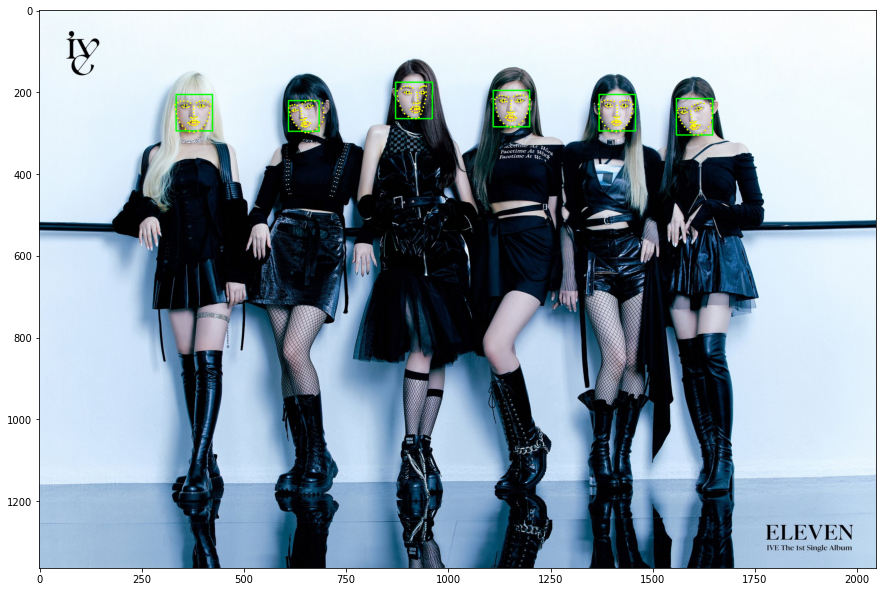

In [21]:
list_landmarks = []

for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)

    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)


for landmark in list_landmarks:
    for point in landmark:
        cv2.circle(img_show_rgb, point, 2, (255,255,0), -1)

plt.figure(figsize=(15,15))
plt.imshow(img_show_rgb)
plt.show()

In [22]:
#이미지 회전
def rotate_image(image, angle):
    image_center = (h//2, w//2)
    mat = cv2.getRotationMatrix2D(image_center, angle, 1.0)                 
    dst = cv2.warpAffine(image, mat, (0,0), borderValue=(0,0,0))   # 회전 후 생기는 빈 부분을 까만색으로 채운다
    return dst

* 2번 과정에서 정의한 이미지 회전 함수를 그대로 사용하지 않은 이유

  스티커의 배경이 까만색이므로 회전 후 생기는 빈 부분에 대하여 까만색으로 채워줘야하기 때문

검출된 얼굴 영역과 랜드마크를 돌며 각 얼굴에 맞춰 스티커 이미지를 변환하고 적용시킨다.

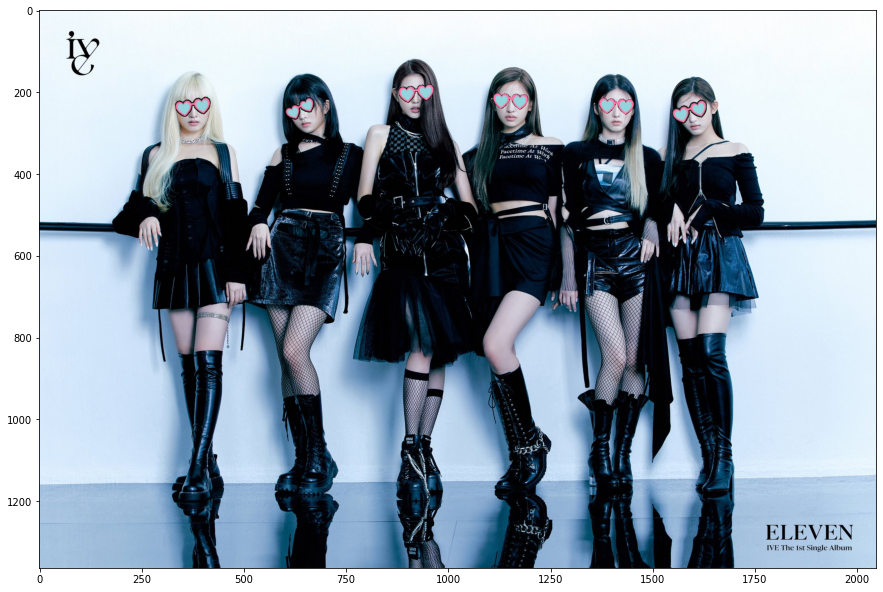

In [23]:
plt.figure(figsize=(15,15))

for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    x = landmark[27][0]
    y = landmark[27][1]
    w = h = dlib_rect.width()
    
    # 콧대를 기준으로 기울기 찾기
    tan_theta = (landmark[30][0]-landmark[27][0])/(landmark[30][1]-landmark[27][1]) 
    theta = math.degrees(math.atan(tan_theta))

    
    # 스티커 이미지 변형
    img_sticker = cv2.resize(img_sticker, (w,h))
    img_sticker = rotate_image(img_sticker, theta)
    
    refined_x = x - w // 2
    refined_y = y - h // 2
    
    if refined_x < 0: 
        img_sticker = img_sticker[:, -refined_x:]
        refined_x = 0
    if refined_y < 0:
        img_sticker = img_sticker[-refined_y:, :]
        refined_y = 0
        
    # 스티커 영역 정의
    sticker_area = img_rgb[refined_y:refined_y+h, refined_x:refined_x+w]
    
    # 얼굴 영역에서 스티커를 적용할 부분 선택
    img_rgb[refined_y:refined_y+h, refined_x:refined_x+w]= \
    np.where(img_sticker==0,sticker_area,img_sticker).astype(np.uint8)
    
    plt.imshow(img_rgb)

plt.show()

### * 모든 사람의 얼굴에 스티커가 적절히 합성되었으므로 성공!! ヽ(^。^)丿

전체 이미지에서 얼굴이 차지하는 영역이 작아도 랜드마크가 잘 검출이 되었다.  
이를 바탕으로 스티커를 적절한 곳에 위치시킬 수 있었다.

### - 어두운 이미지

밝기가 어두운 이미지에도 잘 적용이 될까?

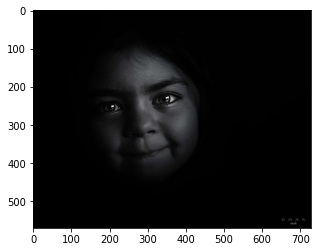

rectangles[[(134, 134) (455, 455)]]


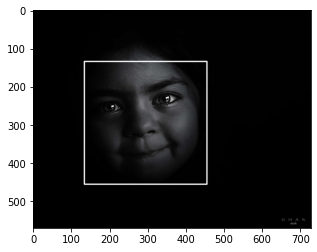

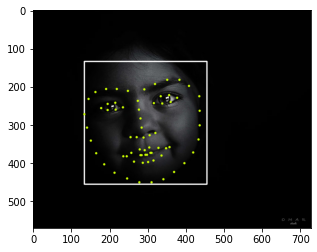

(x,y) : (290,349)
(w,h) : (322,322)
rotation degree : 8.130102354155978


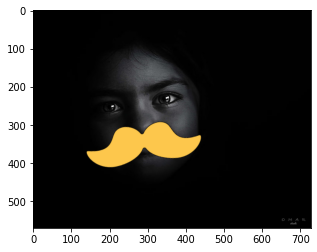

In [24]:
# 원본 이미지 로드 및 확인
my_image_path = os.getcwd()+'/data/d.jpg'

img_bgr = cv2.imread(my_image_path)
img_show = img_bgr.copy() # 중간 확인용 이미지 복사

img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)  #RGB 순서로 변환

plt.imshow(img_rgb)
plt.show()


# 얼굴 영역 검출
detector_hog = dlib.get_frontal_face_detector()

dlib_rects = detector_hog(img_rgb, 1)

print(dlib_rects)


# bounding box 그리기
for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(img_show, (l,t), (r,b), (255,255,255), 2, lineType=cv2.LINE_AA)

img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()


# 랜드마크 검출
list_landmarks = []

for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)

    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)


for landmark in list_landmarks:
    for point in landmark:
        cv2.circle(img_show_rgb, point, 3, (204,255,0), -1)

plt.imshow(img_show_rgb)
plt.show()


# 기준 좌표 및 회전 각도 찾기
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    x = (landmark[33][0] + landmark[51][0]) // 2
    y = (landmark[33][1] + landmark[51][1]) // 2
    w = h = dlib_rect.width()
    
    # 콧대를 기준으로 기울기 찾기
    tan_theta = (landmark[30][0]-landmark[27][0])/(landmark[30][1]-landmark[27][1]) 
    theta = math.degrees(math.atan(tan_theta))
   
    print ('(x,y) : (%d,%d)'%(x,y))
    print ('(w,h) : (%d,%d)'%(w,h))
    print('rotation degree :', theta)
    
    
# 스티커 불러오기
sticker_path = os.getcwd()+'/data/mustache.png'
img_sticker = cv2.imread(sticker_path)
img_sticker = cv2.cvtColor(img_sticker, cv2.COLOR_BGR2RGB)


# 스티커 이미지 변형
img_sticker = cv2.resize(img_sticker, (w,h))
img_sticker = rotate_image(img_sticker, theta)


# 스티커 위치 선정
refined_x = x - w // 2
refined_y = y - w // 2
    
if refined_x < 0:
    img_sticker = img_sticker[:, -refined_x:]
    refined_x = 0
if refined_y < 0:
    img_sticker = img_sticker[-refined_y:, :]
    refined_y = 0
        

# 스티커 영역 정의
sticker_area = img_rgb[refined_y:refined_y+h, refined_x:refined_x+w]

# 얼굴 영역에서 스티커를 적용할 부분 선택
img_rgb[refined_y:refined_y+h, refined_x:refined_x+w]= \
np.where(img_sticker==0,sticker_area,img_sticker).astype(np.uint8)


plt.imshow(img_rgb)
plt.show()

### * 스티커가 적절한 위치에 합성되었으므로 성공!! (*•̀ᴗ•́*)و ̑̑
얼굴 영역과 랜드마크 검출만 성공적으로 수행된다면 스티커를 붙이는 것은 어렵지 않다.  
dlib의 face detector는 육안으로 구분이 힘든 얼굴 왼편의 경계까지 찾아낼 정도로 성능이 좋은 듯 하다.

## 5. 회고

#### (1) 투명 배경 스티커

분명 배경이 투명한 png 파일을 원본 이미지 위에 올렸는데 고양이 수염이 사라지고 흰 배경만 남아있는 현상이 발생했다.  
스티커 이미지를 화면에 띄워 확인해보니, 노드 학습에서 이용한 스티커 이미지는 투명 배경이 까만색으로 표현이 되었는데 프로젝트에 사용한 고양이 수염 스티커는 배경이 흰색으로 표현이 됐기 때문에 생긴 문제였다.  
np.where의 사용법을 찾아 공부하고, 조건 부분을 수정하여 까만 수염부분만 남을 수 있도록 하였다.  


#### (2) 여러 인물이 있는 사진

단지 얼굴 검출하는 반복문과 마찬가지로 하면 될 줄 알았는데 생각보다 반복문 안에 들어가야할 내용이 많아서 구현하는데 오래걸렸다.  
지금 다시 보니 어려운 내용은 아닌데 급하게 하다보니 실수가 눈에 들어오지 않았던 것 같다.  
앞으로 구현해야 할 내용이 복잡할수록 조금 더 차근차근 생각할 수 있도록 해야겠다.


#### (3) 이미지 회전

기존에 알고있던 이미지 회전 방법을 적용했더니 스티커가 틀어진만큼 생기는 빈 공간이 까만색으로 채워졌다.   
wrapAffine 함수의 borderValue는 기본값이 까만색이었던 것이다.  
borderValue에 흰색을 넣어 첫 번째 스티커의 배경을 처리하였다.


#### (4) bounding box 색 선정

RGB 색상표를 참고하여 bounding box와 landmark 색을 이리저리 바꾸어보며 많은 재미를 느꼈다.   
최종 결과 이미지에는 드러나지 않는 부분이지만 중간중간 직접 눈으로 확인을 할 때 훨씬 수월하게 도와주는 장치라는 생각이 들었다.  
이미지의 전반적인 색상에 따라 적절한 색을 잘 고르는 것도 중요한 것 같다.




## 6. 참고 자료

- np.where  
  https://codetorial.net/numpy/functions/numpy_where.html
  
  
- 이미지 회전  
  https://deep-learning-study.tistory.com/175


- RGB 색상표  
  http://www.n2n.pe.kr/lev-1/color.htm